In [4]:
import numpy as np
from numpy import linspace, max, min, average, std, array, diff, fabs, sqrt, power, round
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import pywt
from scipy import signal
from scipy.signal import firwin, lfilter, iirnotch,filtfilt
from statistics import median
import math
from scipy.integrate import simps
from google.colab import files
#!pip install biosignalsnotebooks
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch,butter, lfilter


In [ ]:
VCC = 3.3
n = 10

Fs = 1000
uploaded = files.upload()

# Leer el archivo
file_name = "Ejercicio.txt"
datos = np.loadtxt(file_name)
datos = datos[:, 6]
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


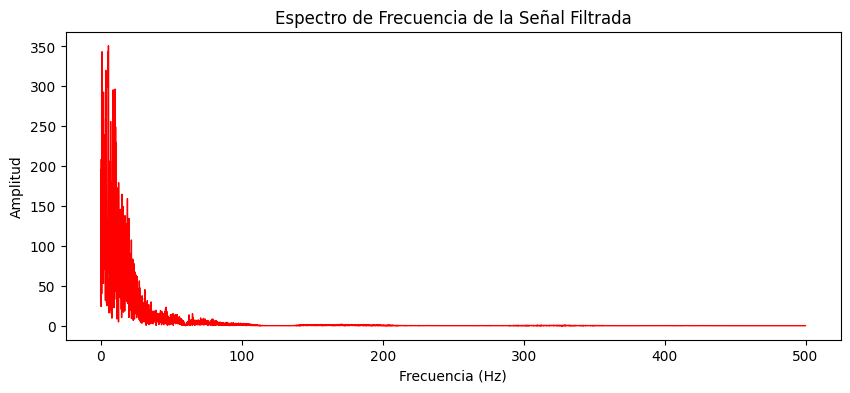

In [50]:
from scipy.fftpack import fft
n = len(datos)
frequencias = np.fft.fftfreq(n, d=1/Fs)
fft_vals = fft(datos)

# Solo tomar la mitad del espectro (ya que la FFT es simétrica)
frequencias = frequencias[:n//2]
fft_vals = fft_vals[:n//2]

# Graficar el espectro de frecuencias
plt.figure(figsize=(10, 4))
plt.plot(frequencias, np.abs(fft_vals), lw=1, color='red')
plt.title("Espectro de Frecuencia de la Señal Filtrada")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.show()

Saving Ejercicio.txt to Ejercicio (11).txt
[478. 473. 475. ... 591. 586. 581.]


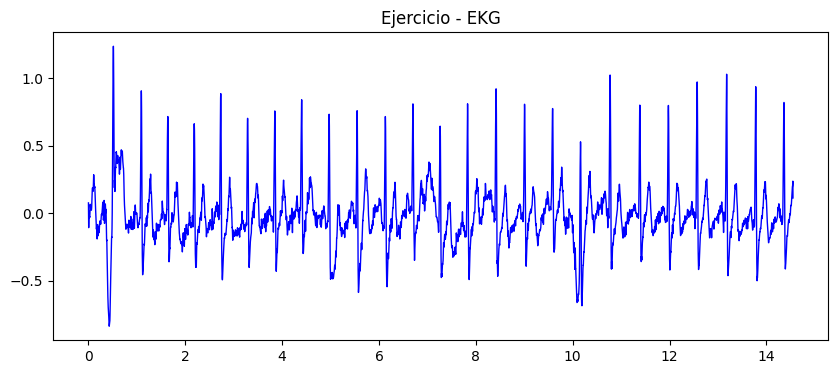

In [46]:
def wavelet_denoising(data, wavelet, level):
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    threshold = np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
    return reconstructed_signal
def notch_filter(data, notch_freq, fs, quality_factor):
    b, a = iirnotch(notch_freq, quality_factor, fs)
    y = filtfilt(b, a, data)
    return y
datos = wavelet_denoising(datos, 'db4', level=3)
notch_freq = 60.0
quality_factor = 30.0
tiempo = np.arange(len(datos)) / Fs
datos = notch_filter(datos, notch_freq, Fs, quality_factor)
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.title("Ejercicio - EKG")
plt.plot(tiempo, datos, lw=1, color='blue')
tachogram_data, tachogram_time = bsnb.tachogram(datos, Fs, signal=True, out_seconds=True)

In [51]:
#Muestra los picos R de la señal ECG - Ejercicio
detected_peaks = bsnb.detect_r_peaks(datos, Fs, time_units=True, plot_result=True)

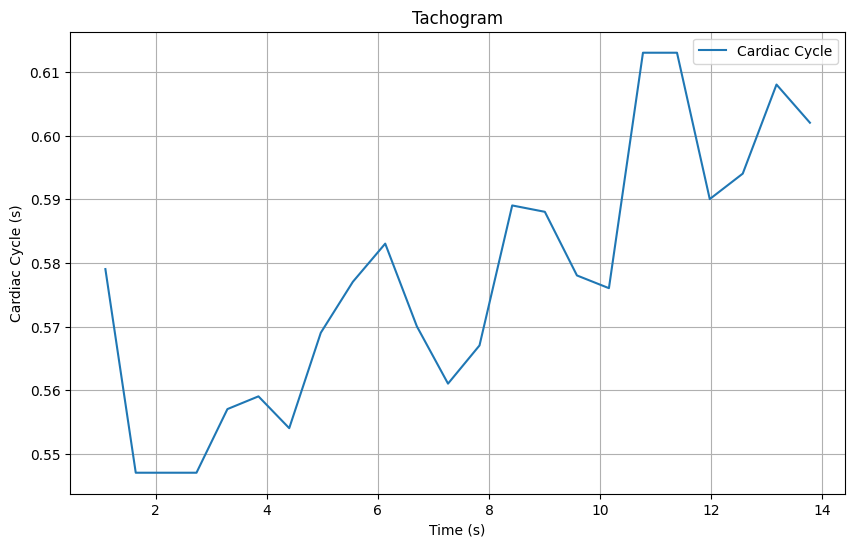

In [48]:
# Graficar el tachograma
plt.figure(figsize=(10, 6))
plt.plot(tachogram_time, tachogram_data, label='Cardiac Cycle')
plt.title('Tachogram')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
tachogram_data_NN, tachogram_time_NN = bsnb.remove_ectopy(tachogram_data, tachogram_time)
bpm_data = (1 / array(tachogram_data_NN)) * 60
print(bpm_data)


[103.61982088 109.68167512 109.68167512 109.68167512 107.71252476
 107.327149   108.29580558 105.62654276 103.79909393 102.90887871
 105.25592331 106.94452101 105.81283296 101.86057095 102.03380321
 103.97898837 103.97898837  98.0324776   97.71315356 101.68792591
 101.00315874  98.67742811  99.66092407]


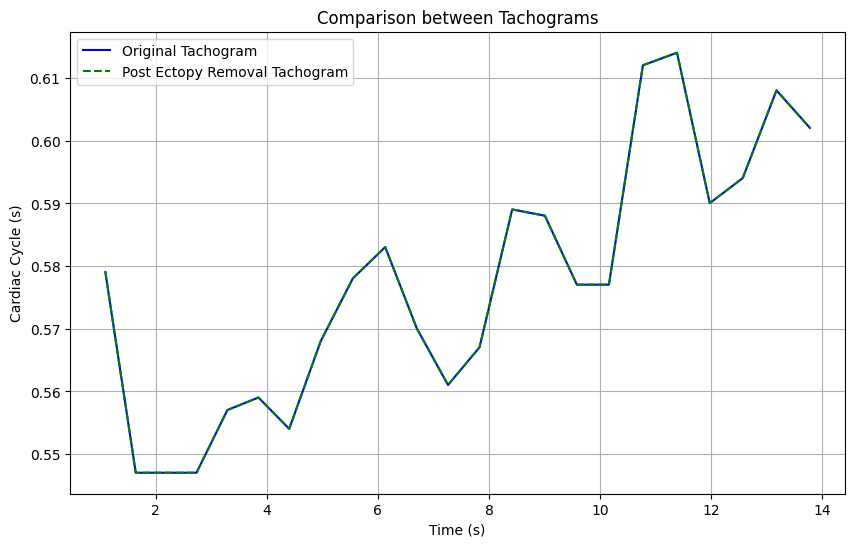

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(tachogram_time, tachogram_data, label='Original Tachogram', color='blue')
plt.plot(tachogram_time_NN, tachogram_data_NN, label='Post Ectopy Removal Tachogram', linestyle='--', color='green')
plt.title('Comparison between Tachograms')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# Maximum, Minimum and Average RR Interval
max_rr = max(tachogram_data_NN)
min_rr = min(tachogram_data_NN)
avg_rr = average(tachogram_data_NN)

# Maximum, Minimum and Average Heart Rate
max_hr = 1 / min_rr # Cycles per second
max_bpm = max_hr * 60 # BPM

min_hr = 1 / max_rr # Cycles per second
min_bpm = min_hr * 60 # BPM

avg_hr = 1 / avg_rr # Cyles per second
avg_bpm = avg_hr * 60 # BPM

# SDNN
sdnn = std(tachogram_data_NN)
# Calcula el RMSSD
rr_diffs = np.diff(tachogram_data_NN)

# Calcula el cuadrado de las diferencias
rr_diffs_sq = rr_diffs ** 2
rmssd = np.sqrt(np.mean(rr_diffs_sq))

time_param_dict = {"Maximum RR": max_rr, "Minimum RR": min_rr, "Average RR": avg_rr, "Maximum BPM": max_bpm, "Minimum BPM": min_bpm, "Average BPM": avg_bpm, "SDNN": sdnn}
print(time_param_dict)

{'Maximum RR': 0.614042202213211, 'Minimum RR': 0.5470375970857102, 'Average RR': 0.5769092153352837, 'Maximum BPM': 109.6816751163799, 'Minimum BPM': 97.71315356459242, 'Average BPM': 104.00249884226524, 'SDNN': 0.020198900674225577}


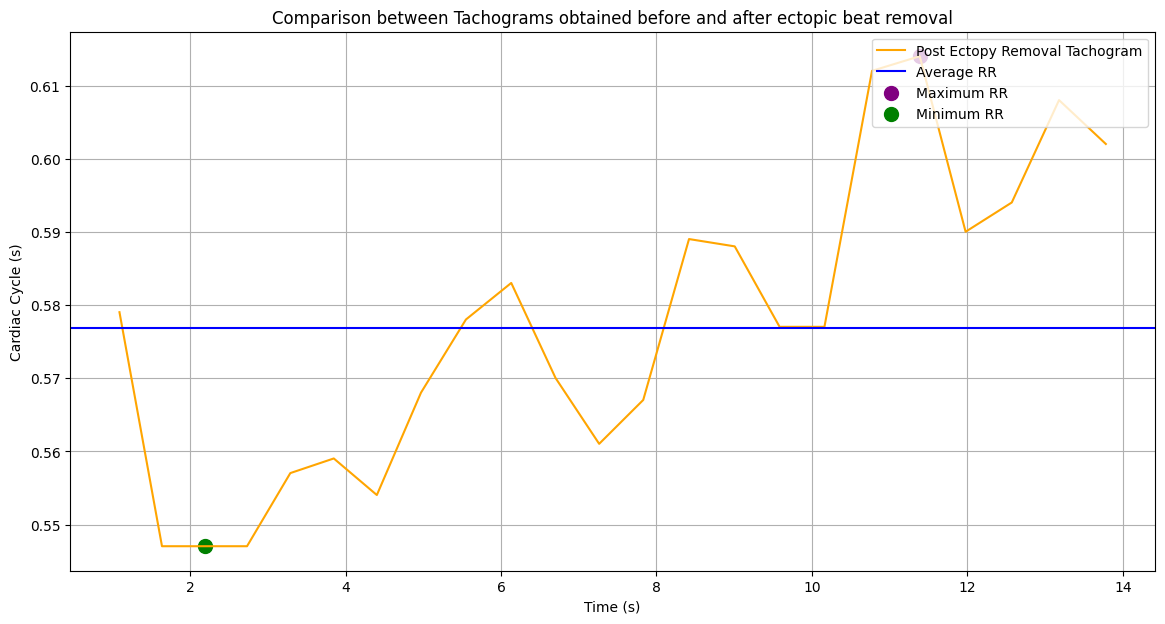

In [14]:
# Graficar el tachograma y los parámetros
plt.figure(figsize=(14, 7))
plt.plot(tachogram_time_NN, tachogram_data_NN, label='Post Ectopy Removal Tachogram', color='orange')

# Agregar líneas y puntos para los parámetros
plt.axhline(y=avg_rr, color='blue', linestyle='-', label='Average RR')
plt.scatter(tachogram_time_NN[np.argmax(tachogram_data_NN)], max_rr, color='purple', s=100, label='Maximum RR')
plt.scatter(tachogram_time_NN[np.argmin(tachogram_data_NN)], min_rr, color='green', s=100, label='Minimum RR')

# Agregar etiquetas y leyenda
plt.title('Comparison between Tachograms obtained before and after ectopic beat removal')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')

# Combinar leyendas de ambos ejes
h1, l1 = plt.gca().get_legend_handles_labels()
plt.legend(h1, l1, loc='upper right')

plt.grid(True)
plt.show()

In [18]:
# Auxiliary Structures
tachogram_diff = diff(tachogram_data)
tachogram_diff_abs = fabs(tachogram_diff)
sdsd = std(tachogram_diff)
rr_i = tachogram_data[:-1]
rr_i_plus_1 = tachogram_data[1:]

# PoincarÃ© Parameters
sd1 = sqrt(0.5 * power(sdsd, 2))
sd2 = sqrt(2 * power(sdnn, 2) - power(sd1, 2))
sd1_sd2 = sd1 / sd2
print("SD1:"+ str(sd1))
print("SD2: "+ str(sd2))
print("SD1/SD2: "+ str(sd1_sd2))

SD1:0.009994951822617493
SD2: 0.02675989751396698
SD1/SD2: 0.3735048617955565


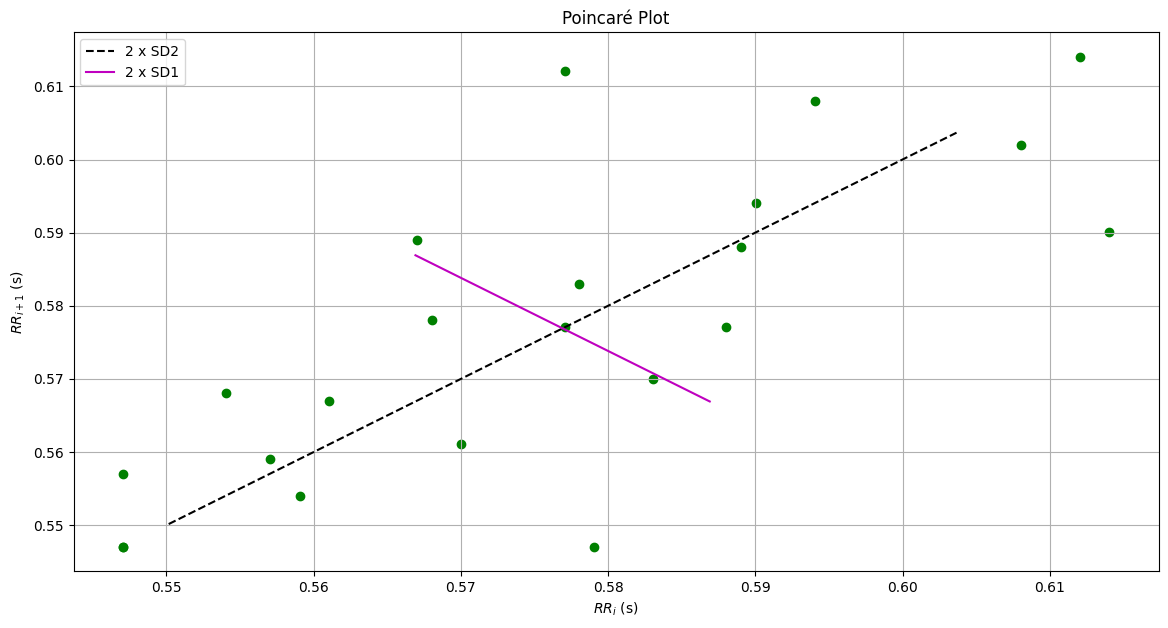

In [19]:
# Graficar el diagrama de Poincaré
plt.figure(figsize=(14, 7))
plt.scatter(rr_i, rr_i_plus_1, color='green')

# Agregar las líneas SD1 y SD2
mean_rr = np.mean(tachogram_data)
plt.plot([mean_rr - sd2, mean_rr + sd2], [mean_rr - sd2, mean_rr + sd2], 'k--', label='2 x SD2')
plt.plot([mean_rr + sd1, mean_rr - sd1], [mean_rr - sd1, mean_rr + sd1], 'm-', label='2 x SD1')

# Agregar etiquetas y leyenda
plt.title('Poincaré Plot')
plt.xlabel(r'$RR_i$ (s)')
plt.ylabel(r'$RR_{i+1}$ (s)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:

# Suponiendo que bsnb.psd ya está definida y devuelve las frecuencias y el espectro de potencia
# Auxiliary Structures
freqs, power_spect = bsnb.psd(tachogram_time, tachogram_data) # Power spectrum.

# Frequemcy Parameters
freq_bands = {"ulf_band": [0.0, 0.003], "vlf_band": [0.003, 0.04], "lf_band": [0.04, 0.15], "hf_band": [0.15, 0.40]}
power_values = {}
total_power = 0

band_keys = freq_bands.keys()
for band in band_keys:
    freq_band = freq_bands[band]
    freq_samples_inside_band = [freq for freq in freqs if freq >= freq_band[0] and freq <= freq_band[1]]
    power_samples_inside_band = [p for p, freq in zip(power_spect, freqs) if freq >= freq_band[0] and freq <= freq_band[1]]
    power = round(np.trapz(power_samples_inside_band, freq_samples_inside_band), 5)

    # Storage of power inside each band
    power_values[band] = power

    # Total power update
    total_power = total_power + power

print(power_values)

{'ulf_band': 0.0, 'vlf_band': 0.0, 'lf_band': 0.0, 'hf_band': 6e-05}


In [22]:
# Number of RR intervals that have a difference in duration, from the previous one, of at least 20 ms
nn20 = sum(1 for i in tachogram_diff_abs if i > 0.02)
pnn20 = int(float(nn20) / len(tachogram_diff_abs) * 100) # Percentage value.

# Number of RR intervals that have a difference in duration, from the previous one, of at least 50 ms
nn50 = sum(1 for i in tachogram_diff_abs if i > 0.05)
pnn50 = int(float(nn50) / len(tachogram_diff_abs) * 100) # Percentage value.
print("NN20: " + str(nn20))
print("PNN20: " + str(pnn20) + "%")
print("NN50: " + str(nn50))
print("PNN50: "+str(pnn50) + "%")

NN20: 4
PNN20: 18%
NN50: 0
PNN50: 0%


<ipython-input-22-7a53b16db7b5>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  nn20 = sum(1 for i in tachogram_diff_abs if i > 0.02)
<ipython-input-22-7a53b16db7b5>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  nn50 = sum(1 for i in tachogram_diff_abs if i > 0.05)


In [23]:
# Supongamos que tienes los siguientes valores calculados

# Crear un diccionario con los datos en filas
time_param_dict = {
    "RR Intervals": {
        "Maximum": max_rr,
        "Minimum": min_rr,
        "Average": avg_rr
    },
    "BPM": {
        "Maximum": max_bpm,
        "Minimum": min_bpm,
        "Average": avg_bpm
    },
    "HRV": {
        "SDNN": sdnn,
        "SD1": sd1,
        "SD2": sd2,
        "SD1/SD2":sd1_sd2,
        "RMSSD": rmssd,
        "NN20": nn20,
        "PNN20": str(pnn20) + "%",
        "NN50": nn50,
        "PNN50": str(pnn50) + "%",
        "Power values": power_values,
        "Total power":total_power,

    }
}

# Imprimir el diccionario
for key, value in time_param_dict.items():
    print(f"{key}:")
    for sub_key, sub_value in value.items():
        print(f"  {sub_key}: {sub_value}")


RR Intervals:
  Maximum: 0.614042202213211
  Minimum: 0.5470375970857102
  Average: 0.5769092153352837
BPM:
  Maximum: 109.6816751163799
  Minimum: 97.71315356459242
  Average: 104.00249884226524
HRV:
  SDNN: 0.020198900674225577
  SD1: 0.009994951822617493
  SD2: 0.02675989751396698
  SD1/SD2: 0.3735048617955565
  RMSSD: 0.014173611019501443
  NN20: 4
  PNN20: 18%
  NN50: 0
  PNN50: 0%
  Power values: {'ulf_band': 0.0, 'vlf_band': 0.0, 'lf_band': 0.0, 'hf_band': 6e-05}
  Total power: 6e-05


In [64]:
uploaded = files.upload()
VCC = 3.3
n = 10
Fs = 1000
# Leer el archivo
file_name = "EstadoBasal.txt"
datos = np.loadtxt(file_name)
datos = datos[:, 6]
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


Saving EstadoBasal.txt to EstadoBasal (5).txt
[500. 504. 506. ... 487. 486. 486.]


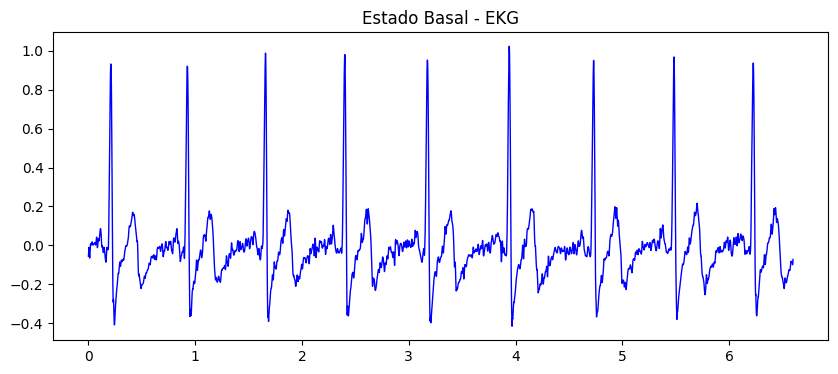

In [65]:

def wavelet_denoising(data, wavelet, level):
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    threshold = np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
    return reconstructed_signal
def notch_filter(data, notch_freq, fs, quality_factor):
    b, a = iirnotch(notch_freq, quality_factor, fs)
    y = filtfilt(b, a, data)
    return y

# usar un butterworld bandpass (5 a 150 Hz)
datos = wavelet_denoising(datos, 'db4', level=3)
notch_freq = 60.0
quality_factor = 30.0
datos = notch_filter(datos, notch_freq, Fs, quality_factor)
# Aplicar el filtro bandpass de 5 a 150 Hz
tiempo = np.arange(len(datos)) / Fs

plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.title("Estado Basal - EKG")
plt.plot(tiempo, datos, lw=1, color='blue')

tachogram_data, tachogram_time = bsnb.tachogram(datos, Fs, signal=True, out_seconds=True)

In [44]:
# Mostramos los picos R de nuestra señal EKG - Estado Basal
detected_peaks = bsnb.detect_r_peaks(datos, Fs, time_units=True, plot_result=True)

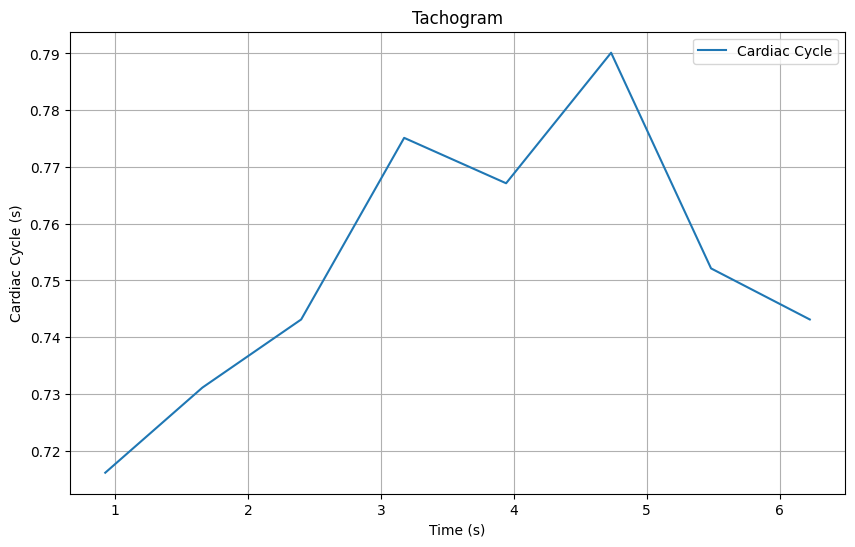

In [66]:
# Graficar el tachograma
plt.figure(figsize=(10, 6))
plt.plot(tachogram_time, tachogram_data, label='Cardiac Cycle')
plt.title('Tachogram')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')
plt.grid(True)
plt.legend()
plt.show()

In [67]:
tachogram_data_NN, tachogram_time_NN = bsnb.remove_ectopy(tachogram_data, tachogram_time)
bpm_data = (1 / array(tachogram_data_NN)) * 60
print(bpm_data)

[83.78618588 82.0669071  80.7414658  77.40762463 78.21500533 75.93785961
 79.77514507 80.7414658 ]


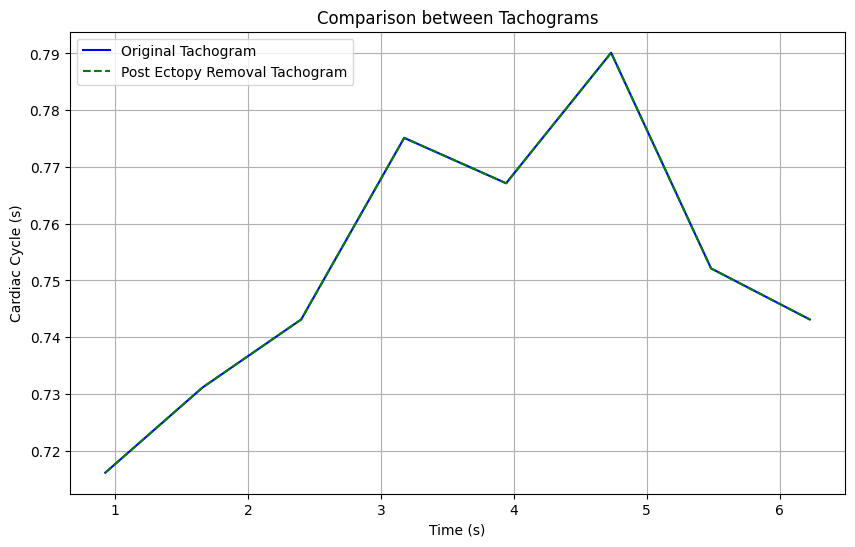

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(tachogram_time, tachogram_data, label='Original Tachogram', color='blue')
plt.plot(tachogram_time_NN, tachogram_data_NN, label='Post Ectopy Removal Tachogram', linestyle='--', color='green')
plt.title('Comparison between Tachograms')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')
plt.grid(True)
plt.legend()
plt.show()

In [69]:
# Maximum, Minimum and Average RR Interval
max_rr = max(tachogram_data_NN)
min_rr = min(tachogram_data_NN)
avg_rr = average(tachogram_data_NN)

# Maximum, Minimum and Average Heart Rate
max_hr = 1 / min_rr # Cycles per second
max_bpm = max_hr * 60 # BPM

min_hr = 1 / max_rr # Cycles per second
min_bpm = min_hr * 60 # BPM

avg_hr = 1 / avg_rr # Cyles per second
avg_bpm = avg_hr * 60 # BPM

# SDNN
sdnn = std(tachogram_data_NN)

time_param_dict = {"Maximum RR": max_rr, "Minimum RR": min_rr, "Average RR": avg_rr, "Maximum BPM": max_bpm, "Minimum BPM": min_bpm, "Average BPM": avg_bpm, "SDNN": sdnn}
print(time_param_dict)

{'Maximum RR': 0.7901197151083501, 'Minimum RR': 0.7161085012880739, 'Average RR': 0.752238975602364, 'Maximum BPM': 83.78618588115795, 'Minimum BPM': 75.93785960874565, 'Average BPM': 79.76188677534863, 'SDNN': 0.022633263020065457}


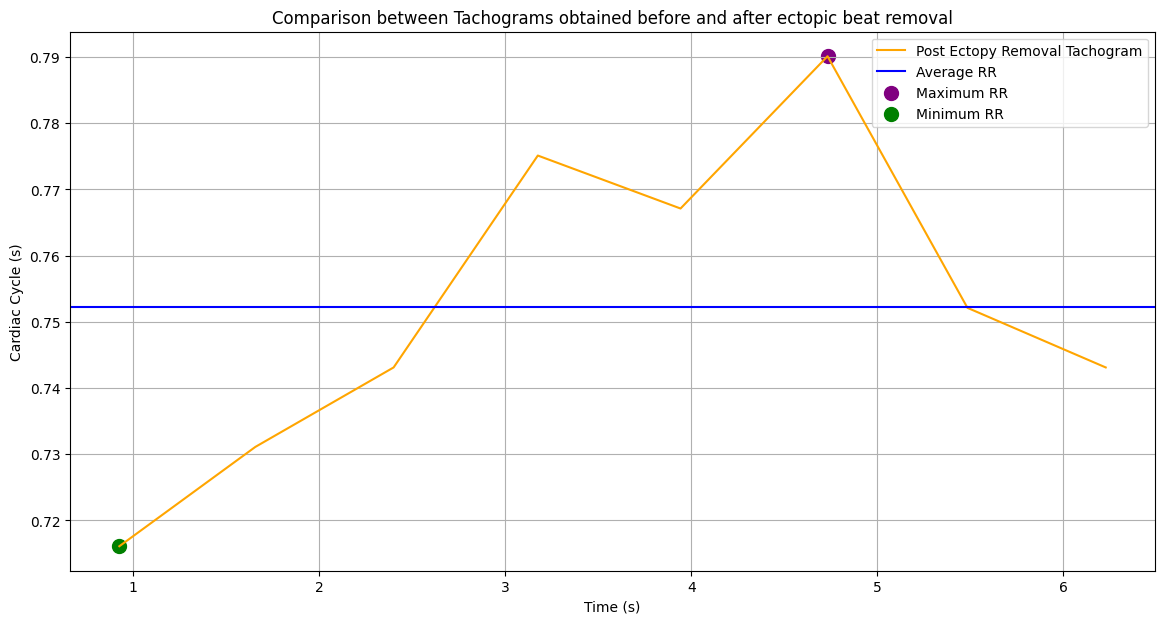

In [70]:
# Graficar el tachograma y los parámetros
plt.figure(figsize=(14, 7))
plt.plot(tachogram_time_NN, tachogram_data_NN, label='Post Ectopy Removal Tachogram', color='orange')

# Agregar líneas y puntos para los parámetros
plt.axhline(y=avg_rr, color='blue', linestyle='-', label='Average RR')
plt.scatter(tachogram_time_NN[np.argmax(tachogram_data_NN)], max_rr, color='purple', s=100, label='Maximum RR')
plt.scatter(tachogram_time_NN[np.argmin(tachogram_data_NN)], min_rr, color='green', s=100, label='Minimum RR')

# Agregar etiquetas y leyenda
plt.title('Comparison between Tachograms obtained before and after ectopic beat removal')
plt.xlabel('Time (s)')
plt.ylabel('Cardiac Cycle (s)')

# Combinar leyendas de ambos ejes
h1, l1 = plt.gca().get_legend_handles_labels()
plt.legend(h1, l1, loc='upper right')

plt.grid(True)
plt.show()

In [77]:
sqrt = np.sqrt
power = np.power
diff = np.diff
fabs = np.fabs
std = np.std

# Auxiliary Structures
tachogram_diff = diff(tachogram_data)
tachogram_diff_abs = fabs(tachogram_diff)
sdsd = std(tachogram_diff)
rr_i = tachogram_data[:-1]
rr_i_plus_1 = tachogram_data[1:]
sd1 = sqrt(0.5 * power(sdsd, 2))
sd2 = sqrt(2 * power(std(tachogram_data), 2) - power(sd1, 2))
sd1_sd2 = sd1 / sd2

print(sd1)
print(sd2)
print(sd1_sd2)

0.015601945296498526
0.027948318247007147
0.5582427235373729


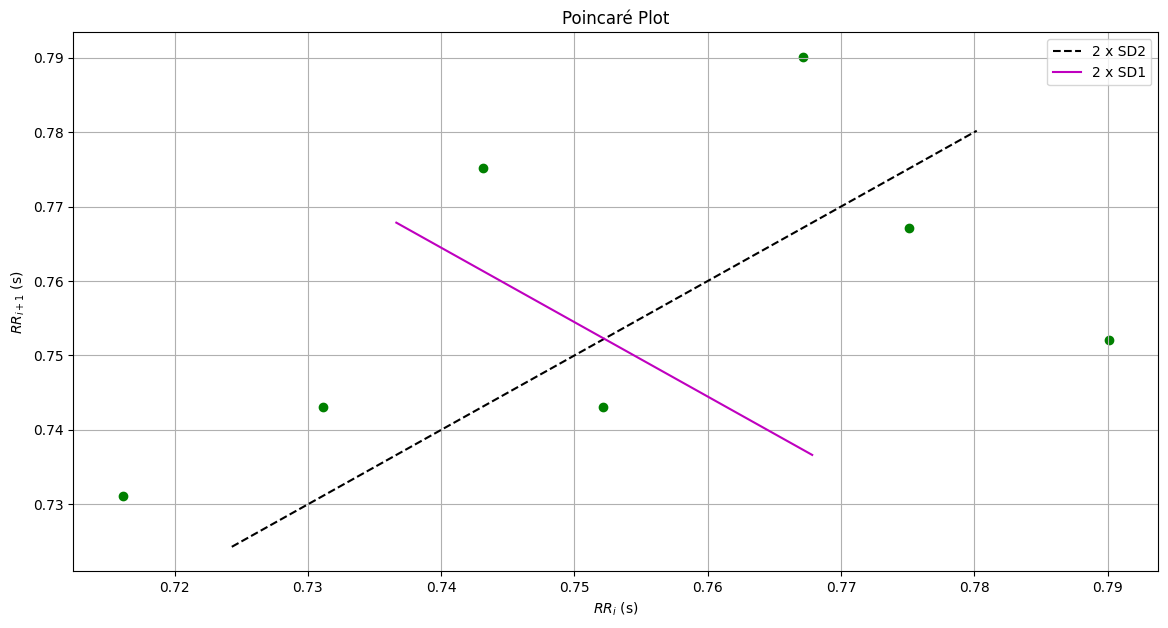

In [78]:
# Graficar el diagrama de Poincaré
plt.figure(figsize=(14, 7))
plt.scatter(rr_i, rr_i_plus_1, color='green')

# Agregar las líneas SD1 y SD2
mean_rr = np.mean(tachogram_data)
plt.plot([mean_rr - sd2, mean_rr + sd2], [mean_rr - sd2, mean_rr + sd2], 'k--', label='2 x SD2')
plt.plot([mean_rr + sd1, mean_rr - sd1], [mean_rr - sd1, mean_rr + sd1], 'm-', label='2 x SD1')

# Agregar etiquetas y leyenda
plt.title('Poincaré Plot')
plt.xlabel(r'$RR_i$ (s)')
plt.ylabel(r'$RR_{i+1}$ (s)')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Auxiliary Structures
freqs, power_spect = bsnb.psd(tachogram_time, tachogram_data) # Power spectrum.

# Frequemcy Parameters
freq_bands = {"ulf_band": [0.0, 0.003], "vlf_band": [0.003, 0.04], "lf_band": [0.04, 0.15], "hf_band": [0.15, 0.40]}
power_values = {}
total_power = 0

band_keys = freq_bands.keys()
for band in band_keys:
    freq_band = freq_bands[band]
    freq_samples_inside_band = [freq for freq in freqs if freq >= freq_band[0] and freq <= freq_band[1]]
    power_samples_inside_band = [p for p, freq in zip(power_spect, freqs) if freq >= freq_band[0] and freq <= freq_band[1]]
    power = round(np.trapz(power_samples_inside_band, freq_samples_inside_band), 5)

    # Storage of power inside each band
    power_values[band] = power

    # Total power update
    total_power = total_power + power

print(power_values)

{'ulf_band': 0.0, 'vlf_band': 0.0, 'lf_band': 0.0, 'hf_band': 0.00012}


In [80]:
# Number of RR intervals that have a difference in duration, from the previous one, of at least 20 ms
nn20 = sum(1 for i in tachogram_diff_abs if i > 0.02)
pnn20 = int(float(nn20) / len(tachogram_diff_abs) * 100) # Percentage value.

# Number of RR intervals that have a difference in duration, from the previous one, of at least 50 ms
nn50 = sum(1 for i in tachogram_diff_abs if i > 0.05)
pnn50 = int(float(nn50) / len(tachogram_diff_abs) * 100) # Percentage value.

<ipython-input-80-236a111912f9>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  nn20 = sum(1 for i in tachogram_diff_abs if i > 0.02)
<ipython-input-80-236a111912f9>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  nn50 = sum(1 for i in tachogram_diff_abs if i > 0.05)


In [81]:
# Crear un diccionario con los datos en filas
time_param_dict = {
    "RR Intervals": {
        "Maximum": max_rr,
        "Minimum": min_rr,
        "Average": avg_rr
    },
    "BPM": {
        "Maximum": max_bpm,
        "Minimum": min_bpm,
        "Average": avg_bpm
    },
    "HRV": {
        "SDNN": sdnn,
        "SD1": sd1,
        "SD2": sd2,
        "SD1/SD2":sd1_sd2,
        "NN20": nn20,
        "PNN20": str(pnn20) + "%",
        "NN50": nn50,
        "PNN50": str(pnn50) + "%",
        "Power values": power_values,
        "Total power":total_power,

    }
}

# Imprimir el diccionario
for key, value in time_param_dict.items():
    print(f"{key}:")
    for sub_key, sub_value in value.items():
        print(f"  {sub_key}: {sub_value}")

RR Intervals:
  Maximum: 0.7901197151083501
  Minimum: 0.7161085012880739
  Average: 0.752238975602364
BPM:
  Maximum: 83.78618588115795
  Minimum: 75.93785960874565
  Average: 79.76188677534863
HRV:
  SDNN: 0.022633263020065457
  SD1: 0.015601945296498526
  SD2: 0.027948318247007147
  SD1/SD2: 0.5582427235373729
  NN20: 3
  PNN20: 42%
  NN50: 0
  PNN50: 0%
  Power values: {'ulf_band': 0.0, 'vlf_band': 0.0, 'lf_band': 0.0, 'hf_band': 0.00012}
  Total power: 0.00012
